# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

import re

from datetime import datetime

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


# Analysis

## Load data

In [2]:
movies = pd.read_csv('ml-100k/u.item', sep='|', encoding='iso-8859-1', header=None, names=['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
'Thriller', 'War', 'Western'])
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['user id', 'movie id', 'rating', 'timestamp'])

In [3]:
movies.head(3)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
def extract_year(title):
    year_search = re.search(r'\((\d{4})\)', title)

    if year_search:
        year = int(year_search.group(1))
    else:
        year = np.nan
        
    return year

movies['year'] = movies['movie title'].apply(extract_year)
movies.index = movies['movie id']
movies['year'].head(3)

movie id
1    1995.0
2    1995.0
3    1995.0
Name: year, dtype: float64

In [5]:
ratings.head(3)

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [6]:
def extract_year_from_timestamp(timestamp):
    return int(datetime.fromtimestamp(timestamp).strftime('%Y'))

ratings['year'] = ratings['timestamp'].apply(extract_year_from_timestamp)

In [7]:
ratings.head(3)

,user id,movie id,rating,timestamp,year
0,196,242,3,881250949,1997
1,186,302,3,891717742,1998
2,22,377,1,878887116,1997


All ratings are from 1997 or 1998:

In [8]:
ratings['year'].value_counts()

1997    52884
1998    47116
Name: year, dtype: int64

## Basic Task

### a. How many movies have been watched in 1992.

With the data at hand, the question that can be answered is, how many movies have been released in 1992. We can assume that these have in turn also been watched by someone in 1992. The answer is only correct with respect to this specific dataset, since, for example, movies released in India in 1992 are not included. 

In [9]:
mask = movies['year'] == 1992
print('In 1992, {:d} movies have been released.'.format(mask.sum()))

In 1992, 40 movies have been released.


**40 movies have been watched.**

### b. What’s the distribution of the reviews (percentage and absolute numbers) for movies that have been published in 1995.

In [10]:
mask = movies['year'] == 1995
movie_id_1995 = movies.loc[mask, 'movie id']

mask = ratings['movie id'].isin(movie_id_1995)
ratings_movies_from_1995 = ratings.loc[mask, 'rating']

In [11]:
ratings_movies_from_1995_percentage = ratings_movies_from_1995.value_counts(sort=False, 
                                                                            normalize=True) * 100
ratings_movies_from_1995_counts = ratings_movies_from_1995.value_counts(sort=False, 
                                                                        normalize=False)

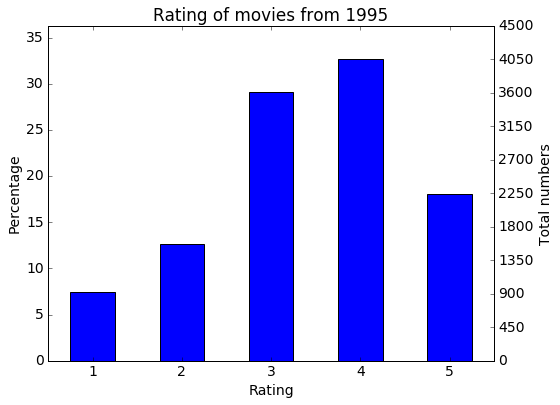

In [12]:
fig = plt.figure(figsize=(8, 6))
ax1 = ratings_movies_from_1995_percentage.plot(kind='bar', rot=0)
ax1.set_ylabel('Percentage')
ax1.set_ylim((0, 4500 * 100 / ratings_movies_from_1995_counts.sum()))
ax1.set_xlabel('Rating')
ax2 = ax1.twinx()

ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks(np.linspace(0, 4500, 11) * 100 / ratings_movies_from_1995_counts.sum())
ax2.set_yticklabels([int(n) for n in np.linspace(0, 4500, 11)])
ax2.set_ylabel('Total numbers')

plt.title('Rating of movies from 1995')
plt.show()

### c. What are the top 10 rated movies in 1996.

It is assumed that the question asks for top 10 rated movies from 1996, since all movie ratings are from 1997 and 1998 (see above). 

Movies with same rating are ranked by numbers of reviews.

In [13]:
# Movie ids of movies from 1996
mask = movies['year'] == 1996
movie_ids_1996 = movies[mask].index

# Identify top 10 rated movie ids of movies from 1996
mask1 = ratings['movie id'].isin(movie_ids_1996)
mask2 = ratings['rating'] == 5  # there are more than 10 movies rated with 5 from the year 1996
mask = mask1 & mask2
top10_ratings = ratings[mask].groupby('movie id').size().sort_values(ascending=False)[:10]
top10_movie_ids = top10_ratings.index

# Find movie titles, put together with ratings and numbers of reviews
top10_movies = movies.loc[top10_movie_ids]
top10_movies['rating'] = [5.0] * 10
top10_movies['number of reviews'] = top10_ratings

# Final output
top10_movies[['movie title', 'rating', 'number of reviews']]

,movie title,rating,number of reviews
movie id,,,
100,Fargo (1996),5.0,227
286,"English Patient, The (1996)",5.0,131
288,Scream (1996),5.0,85
475,Trainspotting (1996),5.0,80
117,"Rock, The (1996)",5.0,77
121,Independence Day (ID4) (1996),5.0,76
237,Jerry Maguire (1996),5.0,75
285,Secrets & Lies (1996),5.0,75
124,Lone Star (1996),5.0,66


# Advanced Task

### a. What are the top 10 similar movies to movie number 16: “French Twist (Gazon maudit) (1995)”.

Crucial for answering this question is how to define similarity. One could use the genre assignment, but that would identify all movies with the single tag 'Action' to be equally similar. However, an established approach for this task is to define similarity with respect to user ratings (item-based collaborative filtering, see *Sawar et al. (2001)*). Two movies that have been similarly rated across users are likely to be similar. I utilize *adjusted cosine similarity* as discussed in *Sawar et al. (2001)*.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim_custom(x, y):
    return cosine_similarity(x.values.reshape(1, -1), y.values.reshape(1, -1))

# Bring rating data into required format
ratings_wide = ratings[['user id', 'movie id', 'rating']].pivot('user id', 'movie id', 'rating')
ratings_wide = ratings_wide.apply(lambda x: x - np.nanmean(x), axis=1)  # subtract user mean
ratings_wide = ratings_wide.fillna(0)  # required for cosine_similarity

# Determine adjusted cosine similarity of movies with respect to user ratings
movie_similarity = pd.DataFrame(np.ones((ratings_wide.shape[1], ratings_wide.shape[1])),
                              index = ratings_wide.columns,
                              columns = ratings_wide.columns)
count = 0
total_count = ratings_wide.shape[1] * (ratings_wide.shape[1]-1) / 2
for i in range(ratings_wide.shape[1]):
    for j in range(i):
        if count % 1000 == 0:
            print('{:.2f}'.format(count/total_count), end='\r')
        count += 1
        mi = movie_similarity.index[i]
        mj = movie_similarity.index[j]
        movie_similarity.loc[mi, mj] = movie_similarity.loc[mj, mi] = cos_sim_custom(ratings_wide[mi], ratings_wide[mj])

# Determine movie id of 'French Twist (1995)'
mask = movies['movie title'].str.contains('French Twist')
french_twist_id = movies[mask].index.get_values()[0]

# Find movies most similar to 'French Twist (1995)'
most_similar = movie_similarity.loc[french_twist_id].nlargest(11).index[1:]  # index zero is french twist
most_similar_movies = movies.loc[most_similar]

**Most similar movies, ordered by decreasing similarity:**

In [15]:
most_similar_movies['movie title']

movie id
1232             Madonna: Truth or Dare (1991)
1447                            Century (1993)
1453               Angel on My Shoulder (1946)
1457               Love Is All There Is (1996)
1460                          Sleepover (1995)
1461                  Here Comes Cookie (1935)
107                       Moll Flanders (1996)
804                     Jimmy Hollywood (1994)
1377                      Hotel de Love (1996)
119     Maya Lin: A Strong Clear Vision (1994)
Name: movie title, dtype: object

### b. I’ve watched the movie “Bad Boys (1995)”, “Braveheart (1995)” and “Taxi Driver (1976)”. Please give a recommendation for the next 3 movies that I should watch. There’s no wrong or right answer but please explain your process and the way you reached your recommendation.


Assumption: All three movies watched were liked and equally well liked.

Under this assumption, I can implement item-item collaborative filtering (*Sawar et al. (2001)*. To this end, I utilize the adjusted cosine similarity of movies (see above). Then I determine for each movie (except the already watched ones) the similarity to the already watched ones and take an average (if ratings were available for the watched ones, I would weight the similarities by the ratings; based on the assumption stated above, I can leave this out). This provides me a similarity score for all other movies. I choose the three with highest similarity. If there are ties, I choose by rank and number of reviews.

In [16]:
# Identify movie ids of these movies
watched_movies = [r'Bad Boys \(1995\)', r'Braveheart \(1995\)', r'Taxi Driver \(1976\)']
watched_movie_ids = []
for m in watched_movies:
    mask = movies['movie title'].str.contains(m)
    watched_movie_ids.append(movies.index[mask].get_values()[0])
    
other_movie_ids = np.setdiff1d(movies.index, (watched_movie_ids))

# Find movie recommendations
recommended_movie_ids = movie_similarity.loc[other_movie_ids, watched_movie_ids].mean(axis=1).nlargest(3).index
recommended_movies = movies.loc[recommended_movie_ids]

**Recommended movies, ordered by decreasing recommendation score:**

In [17]:
recommended_movies['movie title']

movie id
651                        Glory (1989)
64     Shawshank Redemption, The (1994)
127               Godfather, The (1972)
Name: movie title, dtype: object